<a href="https://colab.research.google.com/github/RTae/Shopee-Code-League/blob/master/week3/Competition/Shopee_Code_League_Product_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download file from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/My Drive/Workshops/Shopee Competition/Product-detection/Datasets/Dataset.zip', 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

# Prepare file

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from PIL import Image
import os
from shutil import copyfile
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
TRAIN_DIR = '/tmp/train/train'
TEST_DIR = '/tmp/test/test'

folders = []
for i in range(0,42):
    if i < 10:
        folders.append('0'+str(i))
    else:
        folders.append(str(i))

In [ ]:
def removeNoiseFile(DIR,test = False):
    if test :
      noise = '(1).jpg'
    else :
      noise = '.tmp'
    for file in os.listdir(DIR):
        if((os.path.getsize(DIR+'/'+file) > 0) and (noise not in file)):
            pass
        else:
            os.remove(DIR+'/'+file)
            print(file)

for folder in folders:
    removeNoiseFile(TRAIN_DIR+'/'+folder)
removeNoiseFile(TEST_DIR,test=True)

FileNotFoundError: ignored

In [ ]:
def copyfileFromFolder(path,folders):
  # Copy file from 
  for folder in folders:
    for file in os.listdir(os.path.join(path,folder)):
      copyfile(os.path.join(path,folder,file),os.path.join(path,file))
      os.remove(os.path.join(path,folder,file))
    # Remove folder
    os.rmdir(os.path.join(path,folder))

copyfileFromFolder(TRAIN_DIR,folders)

In [ ]:
TRANING_NUM = len(os.listdir(TRAIN_DIR))
TESTING_NUM = len(os.listdir(TEST_DIR))
df_train = pd.read_csv("/tmp/train.csv", dtype=str)
df_test = pd.read_csv("/tmp/test.csv", dtype=str)

assert TRANING_NUM == df_train.shape[0],'Have noise file' 
assert TESTING_NUM == df_test.shape[0],'Have noise file' 

print('Number of training set : ',TRANING_NUM)
print('Number of training set : ',TESTING_NUM)

# Expected
# Number of training set :  105392
# Number of training set :  12186

Number of training set :  105392
Number of training set :  12186


In [ ]:
df_train_tiny = df_train.sample(int(df_train.shape[0]*0.1),replace=False).reset_index()
df_train_tiny = df_train_tiny.drop('index',axis=1)
df_train_tiny

filename category
0      621a1bfea53abfe1b3546e11f3a27e70.jpg       15
1      413c402c4eccab979df9fe9e3f30ca69.jpg       35
2      8e3dc432c6dfe64e6fe6930411622e98.jpg       24
3      3f1aca72d8d754b224a233d6a5902f8e.jpg       07
4      a2f2500951f8b4f2270a6e01f6ed0f61.jpg       19
...                                     ...      ...
10534  f6c2ae40186c88f4d31c0d93ad7159a4.jpg       06
10535  c4255003adc1a8cbdfcfe82a67f0178e.jpg       25
10536  6d74f242459d82f678b63f75b70cb1d7.jpg       14
10537  7894569be4120c22ed6fda8ef6d5bfee.jpg       09
10538  5f4a6e92c617977474bdc1d24863666c.jpg       07

[10539 rows x 2 columns]

In [ ]:
# pick random samples

dataset_path = {}

categories = np.sort(df_train['category'].unique())

for cat in categories:
    try:
        dataset_path[cat] = df_train[df_train['category'] == cat]['filename'].sample(2200)
    except:
        dataset_path[cat] = df_train[df_train['category'] == cat]['filename'].sample(frac=1.)

In [ ]:
train_paths = {}
c = 0
for idx, key in enumerate(dataset_path.keys()):
  for path in dataset_path[key]:
    train_paths[c]  =  [path,folders[idx]]
    c+=1

In [ ]:
df_sample = pd.DataFrame(train_paths).T
df_sample = df_sample.rename(columns={0: "filename", 1: "category"})
df_sample

filename category
0      5ff42c5646faa11ced95bf486d42e931.jpg       00
1      7e466a1efc71314f3821c008ed5bf78d.jpg       00
2      372b5bb3f98e2438cd4bff4d93a2ec9c.jpg       00
3      fd48afdea0cd6ed7a3b3882bf260878a.jpg       00
4      e4fe0dd92c762d6a6e3f1c919b1a2d51.jpg       00
...                                     ...      ...
89087  1fc12bb70008f6753f10221ae1019253.jpg       41
89088  c8625c1dc480a811e575ced748cf8f7e.jpg       41
89089  3361470bc4223c20fe22f756ba06cb83.jpg       41
89090  e6fe5dad82bf47a7f2549b2c90cb07fd.jpg       41
89091  84edc147fa931d42b40c279ea15ed16c.jpg       41

[89092 rows x 2 columns]

In [ ]:
def splitting_data(df, train_ratio=0.9):
    indices = np.random.choice(df.shape[0], int(train_ratio*df.shape[0]), replace=False)
    remaining = set(df.index) - set(indices)
    df_model = df.loc[indices].reset_index()
    df_val = df.loc[remaining].reset_index()
    return df_model, df_val

df_TRANING, df_VALIDATION = splitting_data(df_train, train_ratio=0.90)
print("Original shape: ", df_train.shape[0])
print("df_model shape: ", df_TRANING.shape[0])
print("df_val shape: ", df_VALIDATION.shape[0])

Original shape:  105392
df_model shape:  94852
df_val shape:  10540


In [ ]:
#df_TRANING.to_csv('/content/drive/My Drive/Workshops/Shopee Competition/Product-detection/df_TRANING.csv')
#df_VALIDATION.to_csv('/content/drive/My Drive/Workshops/Shopee Competition/Product-detection/df_VALIDATION.csv')

In [ ]:
df_TRANING = pd.read_csv('/content/drive/My Drive/Workshops/Shopee Competition/Product-detection/df_TRANING.csv')
df_VALIDATION = pd.read_csv('/content/drive/My Drive/Workshops/Shopee Competition/Product-detection/df_VALIDATION.csv')

df_TRANING['category']=df_TRANING['category'].apply(lambda v: str(int(v)).zfill(2))
df_VALIDATION['category']=df_VALIDATION['category'].apply(lambda v: str(int(v)).zfill(2))

In [ ]:
# init hyper-parameter

IMAGE_SIZE = 300
EPOCHS = 50
BATCH_SIZE = 128
OPTIMIZER = 'adam'
LEARNING_RATE = 0.001

In [ ]:
class_weight = compute_class_weight('balanced',
                                    np.unique(df_TRANING['category']),
                                    df_TRANING['category'])
class_weight = dict(enumerate(class_weight))
class_weight

{0: 0.9355347772911982,
 1: 0.933215269578906,
 2: 0.927847556442462,
 3: 0.9286105889724311,
 4: 0.9328298027182785,
 5: 0.9437446520605735,
 6: 0.9453248021686699,
 7: 0.9492984247082608,
 8: 0.9449292687786411,
 9: 0.9236731911578537,
 10: 0.9255659640905542,
 11: 1.3720418908754268,
 12: 0.9267053559216054,
 13: 0.9339871597936114,
 14: 0.9309072351116869,
 15: 0.9520998956074841,
 16: 0.939035739035739,
 17: 1.5960289416119804,
 18: 1.2012664640324215,
 19: 0.9366988603819795,
 20: 0.9465133916097872,
 21: 0.9676010935651038,
 22: 0.9477049737225985,
 23: 0.9776540919398062,
 24: 0.916922838969124,
 25: 0.939817291877217,
 26: 0.9525014560864413,
 27: 0.9263252470799641,
 28: 0.9831871799655866,
 29: 1.1905012927680296,
 30: 0.921036277479997,
 31: 0.937087532108279,
 32: 1.1659168571920249,
 33: 4.41953219644022,
 34: 0.9610131712259372,
 35: 0.9481028347527088,
 36: 0.933215269578906,
 37: 1.457019969278034,
 38: 0.9363105109373766,
 39: 0.9320598235166951,
 40: 0.94889955982392

In [ ]:
steps_per_epoch = int(df_TRANING.shape[0]/BATCH_SIZE)
validation_steps = int(df_VALIDATION.shape[0]/BATCH_SIZE)

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)

Steps per epoch: 741
Validation steps: 82


# Visualizing images

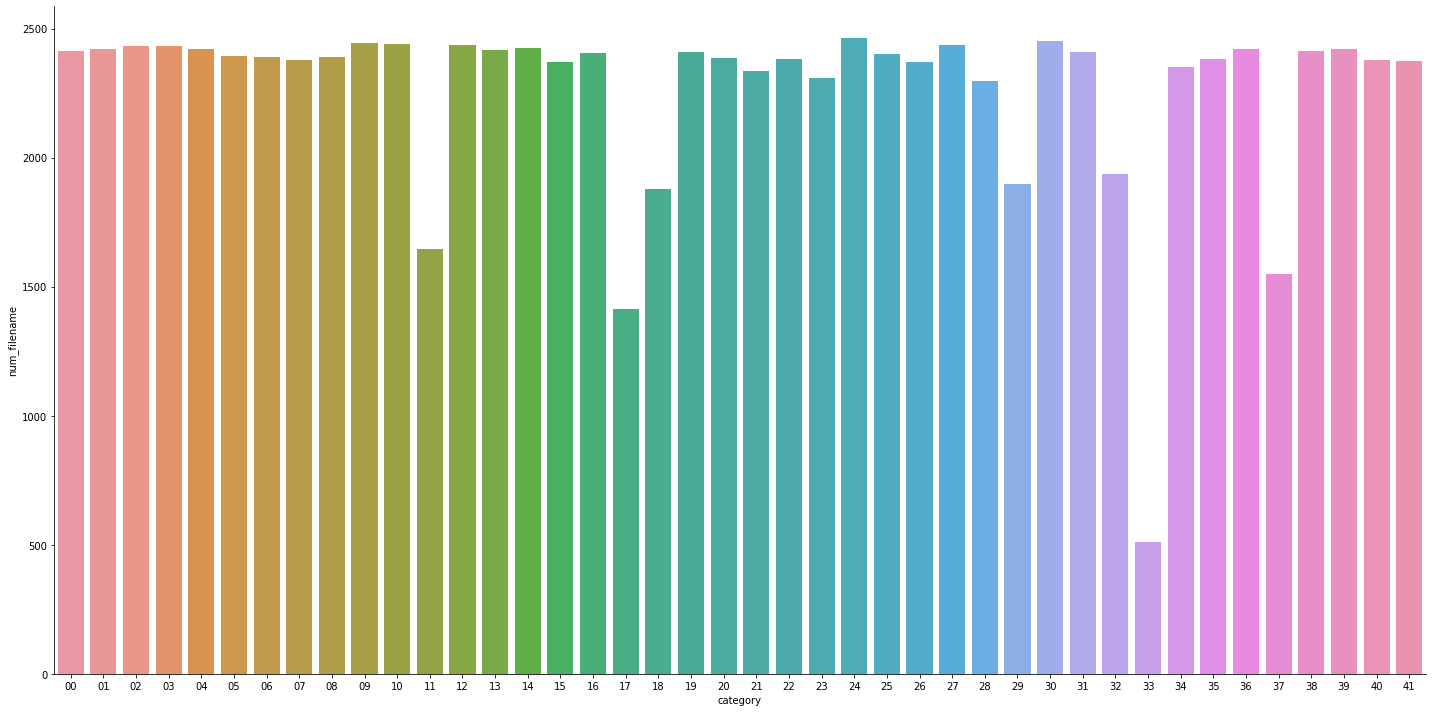

In [ ]:
df_train_count = df_TRANING.groupby('category')['filename'].apply(list).to_frame()
df_train_count['num_filename'] = list(map(lambda x: len(x), df_train_count['filename']))
df_train_count['category'] = df_train_count.index

sns.catplot(x="category", y="num_filename", kind="bar", data=df_train_count,height=10,aspect = 2)

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [ ]:
def showImage(filter = False):
  W_grid = 5
  L_grid = 5
  eraser = get_random_eraser()
  fig, axes = plt.subplots(L_grid, W_grid, figsize = (30,30))
  axes = axes.ravel()

  for i in np.arange(0,W_grid*L_grid):
      indices = np.random.choice(range(df_train.shape[0]),replace=False)
      im = np.array(Image.open(os.path.join(TRAIN_DIR,df_train.loc[indices,'filename'])))
      if filter :
        im = eraser(im)
      else :
        im = im
      axes[i].imshow(im)
      axes[i].set_title(df_train.loc[indices,'category'],fontsize = 20)
      axes[i].axis('OFF')
  plt.subplots_adjust(hspace=0.4)

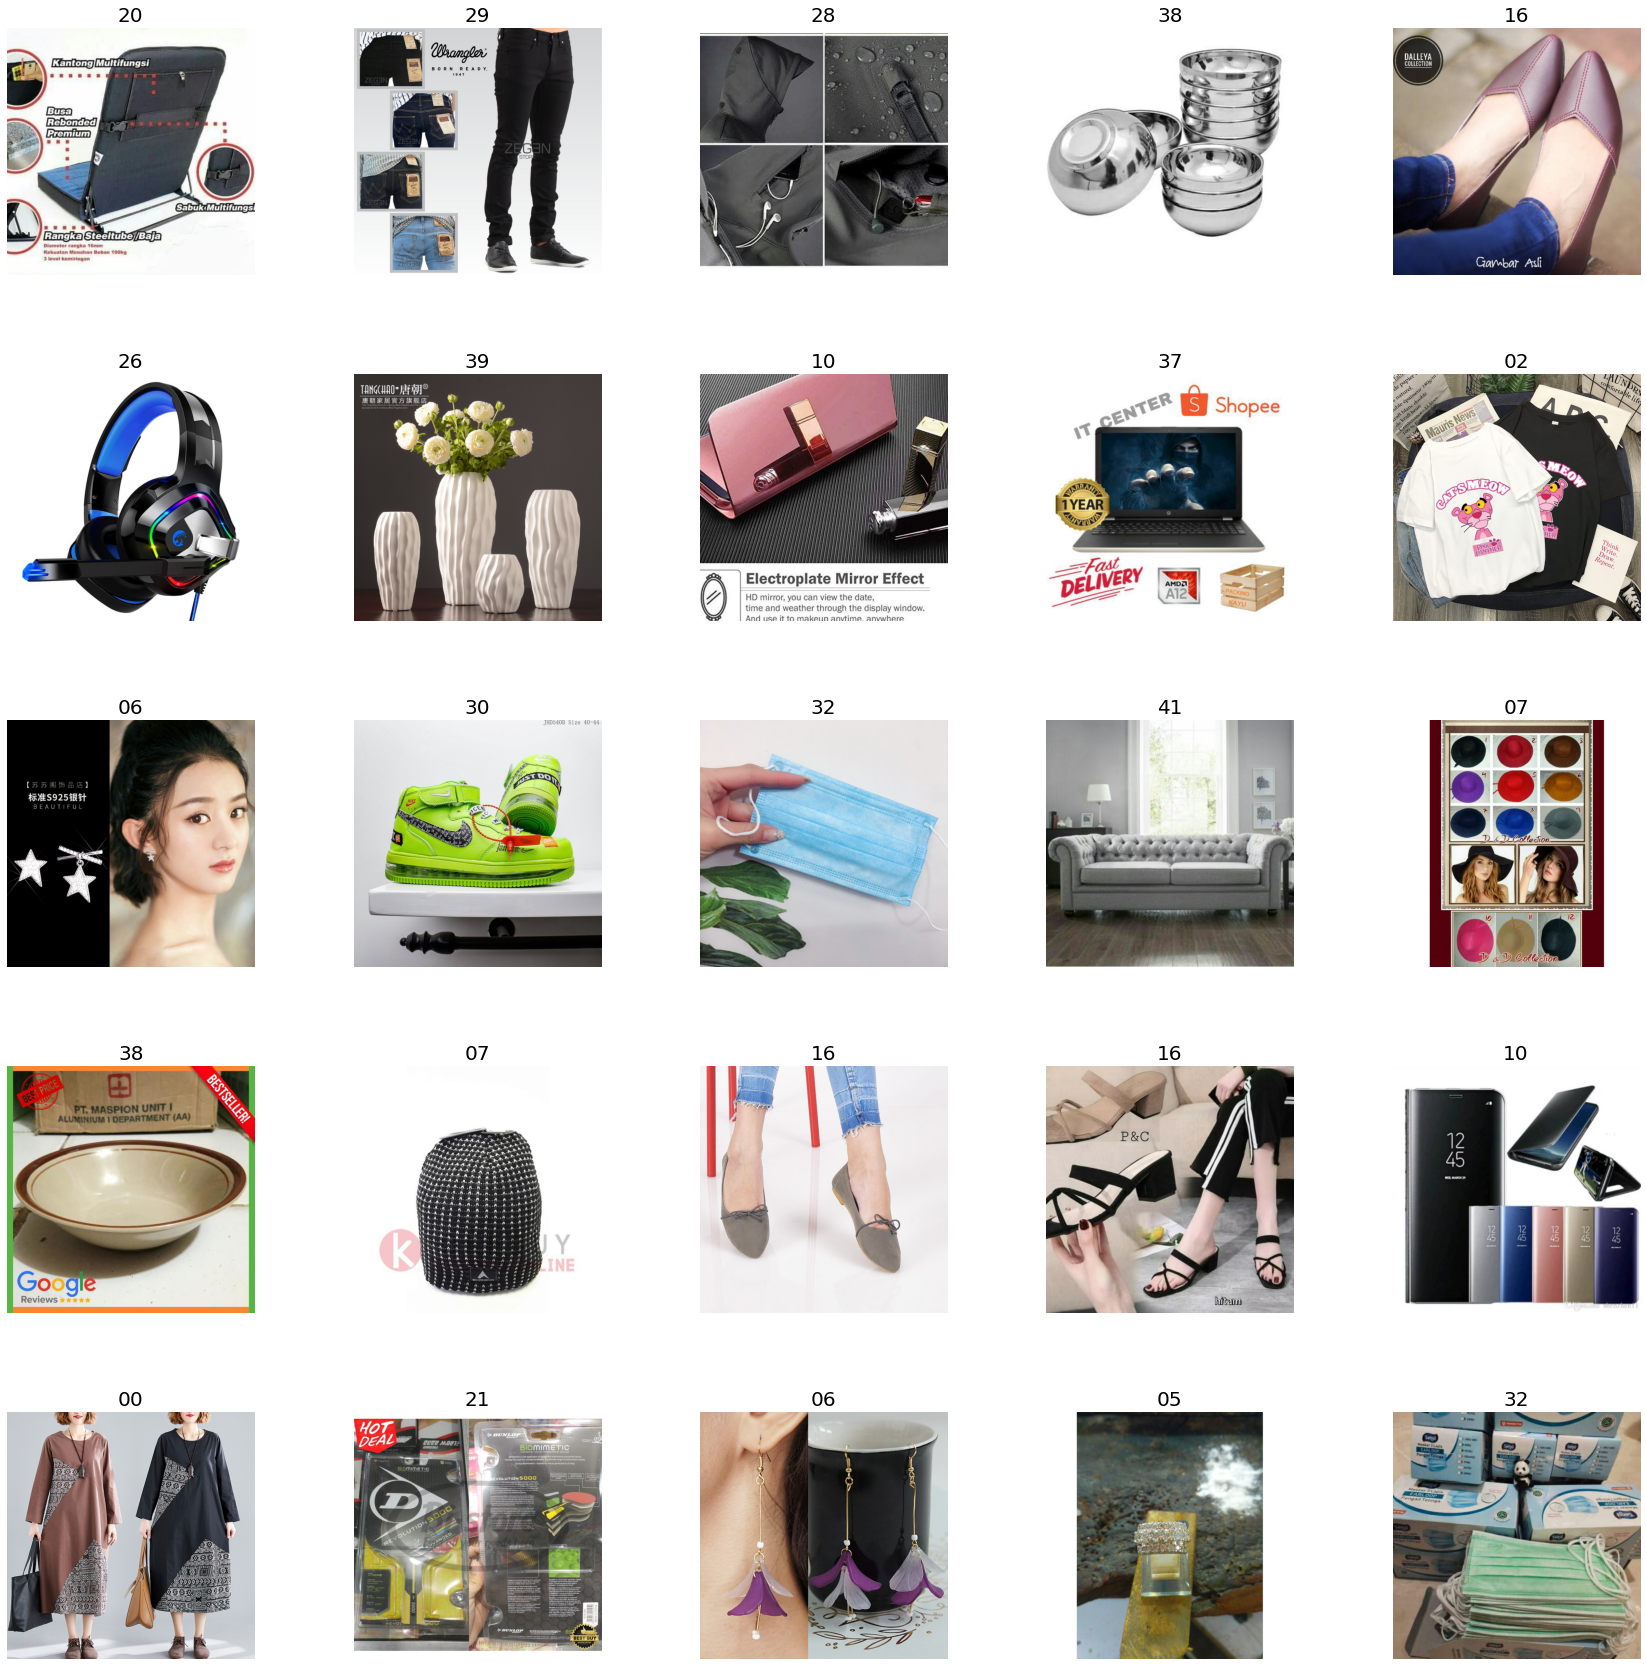

In [ ]:
showImage()

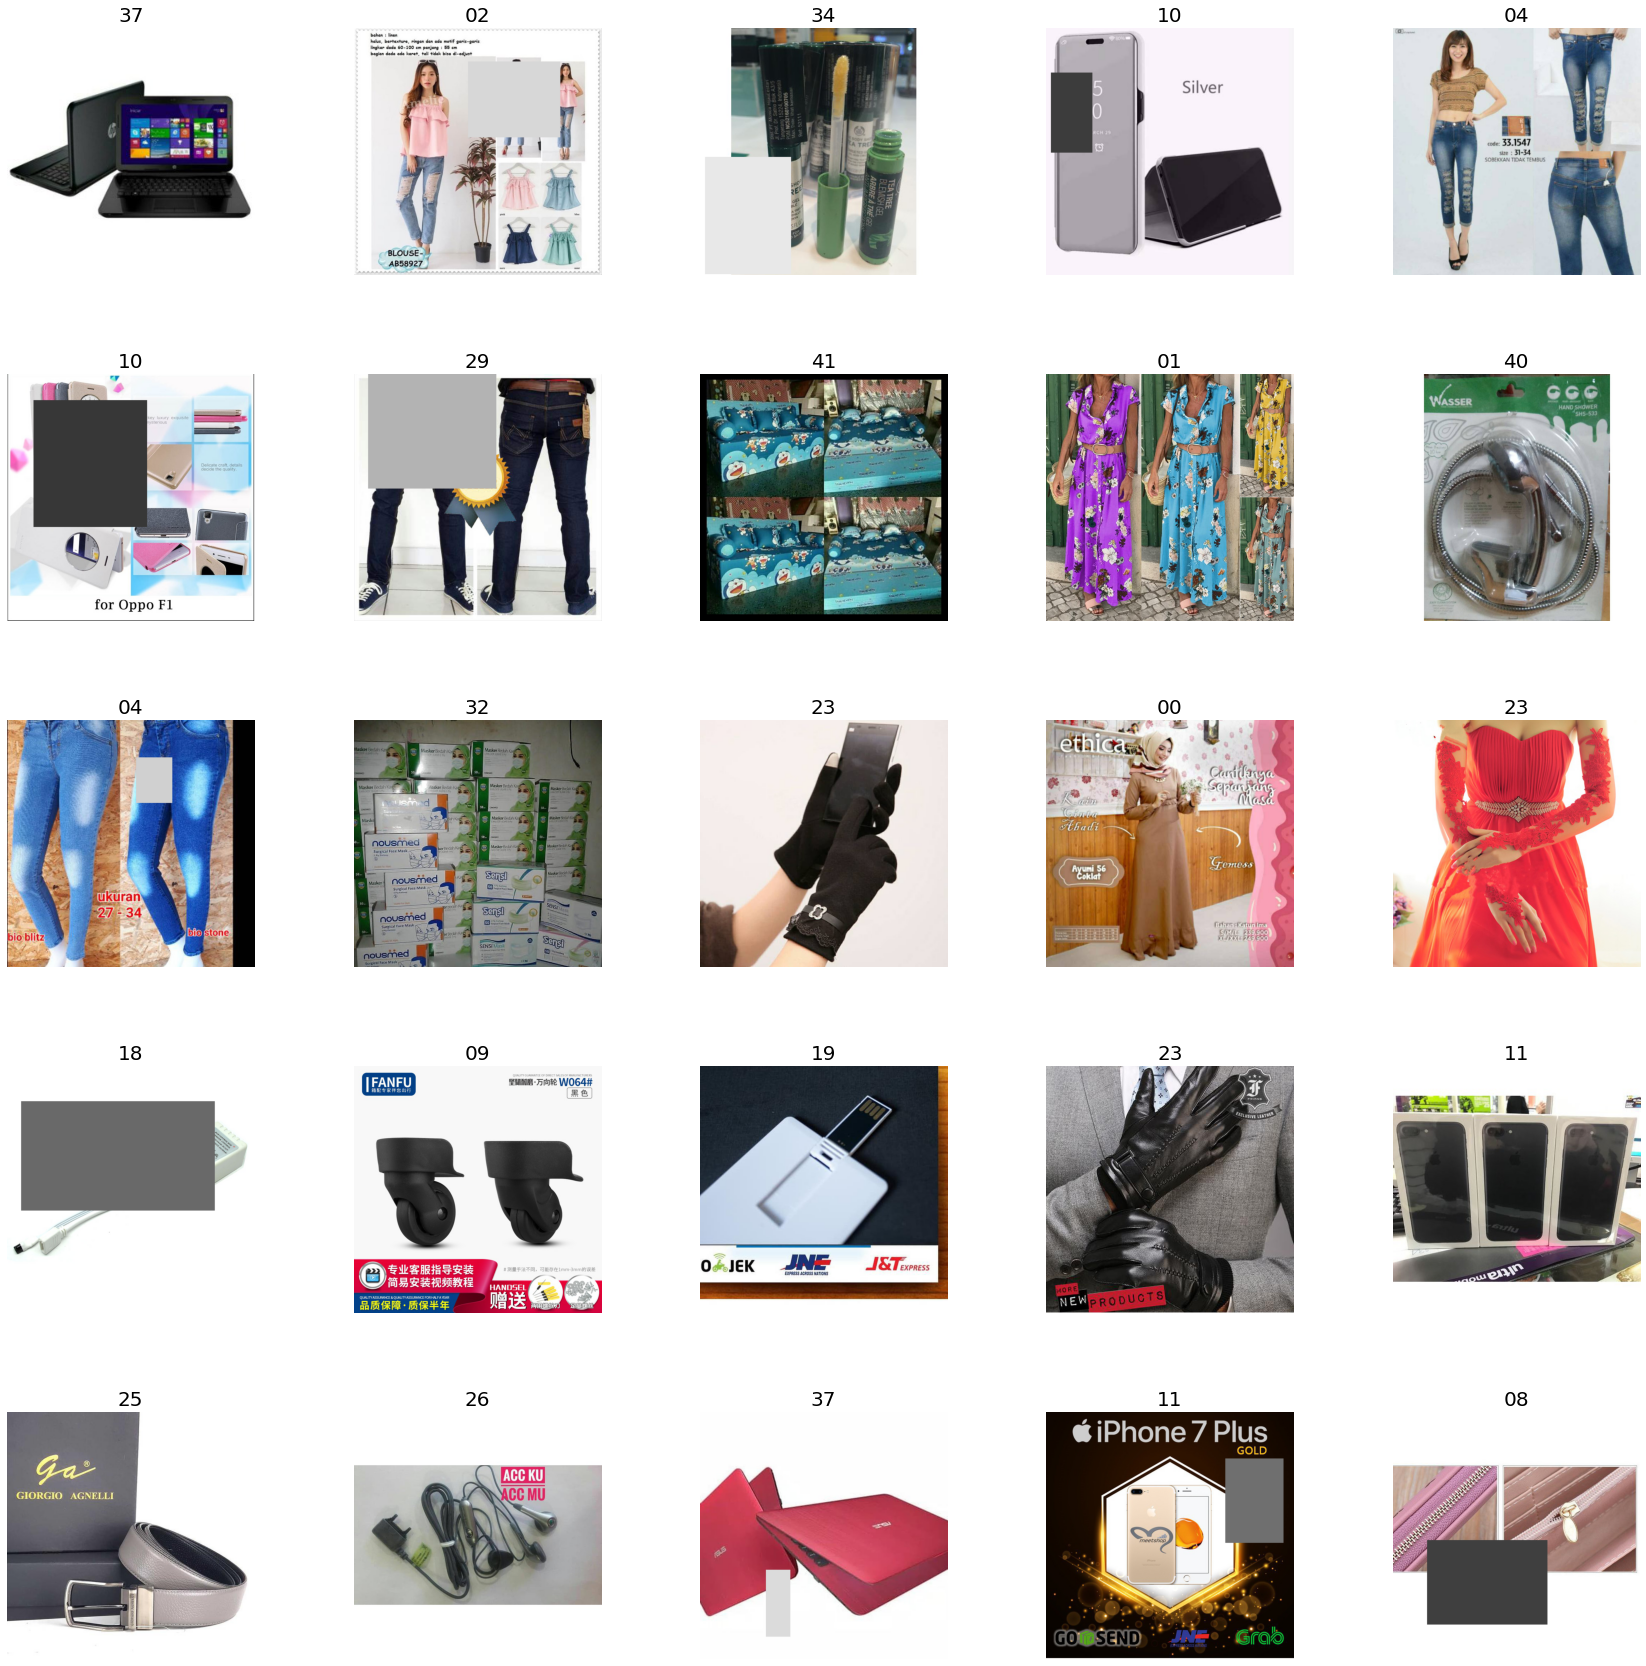

In [ ]:
showImage(filter=True)

In [ ]:
def preprocess_input(img):
    
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    eraser = get_random_eraser(v_l=-1., v_h=1., pixel_level=True, p=0.5)
    img = eraser(img)
    return img

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    df_TRANING,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

validation_generator = validation_datagen.flow_from_dataframe(
    df_VALIDATION,
    directory=TRAIN_DIR,
    x_col='filename',
    y_col='category',
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 94852 validated image filenames belonging to 42 classes.
Found 10540 validated image filenames belonging to 42 classes.


# Traning

In [ ]:
#!pip install -q efficientnet

In [ ]:
from efficientnet.tfkeras import EfficientNetB7
pre_trained_model = EfficientNetB7(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                include_top=False,
                                weights='imagenet',
                                pooling='avg')

for layer in (pre_trained_model.layers):
    layer.trainable = False
pre_trained_model.summary()

258441216/258434480 [==============================] - 17s 0us/step
Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 64) 0           stem_bn[0][0]                    
________________

In [ ]:
model = tf.keras.models.Sequential([
        pre_trained_model,
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(42, activation='softmax')
])
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                10794     
Total params: 64,829,882
Trainable params: 732,202
Non-trainable params: 64,097,680
______________________________________

In [ ]:
from tensorflow import keras
from tensorflow.keras import backend as K


class WarmUpLearningRateScheduler(keras.callbacks.Callback):
    """Warmup learning rate scheduler
    """

    def __init__(self, warmup_batches, init_lr, verbose=0):
        """Constructor for warmup learning rate scheduler
        Arguments:
            warmup_batches {int} -- Number of batch for warmup.
            init_lr {float} -- Learning rate after warmup.
        Keyword Arguments:
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count*self.init_lr/self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %05d: WarmUpLearningRateScheduler setting learning '
                      'rate to %s.' % (self.batch_count + 1, lr))


sample_count = train_generator.samples
warmup_epoch = EPOCHS
batch_size = BATCH_SIZE

warmup_batches = warmup_epoch * sample_count / batch_size
warm_up_lr = WarmUpLearningRateScheduler(warmup_batches, init_lr=LEARNING_RATE)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/Product-Dectection/checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             )

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

cosin_decray_fn = tf.keras.experimental.CosineDecay(LEARNING_RATE/10,EPOCHS-30)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(cosin_decray_fn)

In [ ]:
model.compile(optimizer = OPTIMIZER, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
#model.load_weights(checkpoint_path)

In [ ]:
h = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch= steps_per_epoch,
    validation_steps= validation_steps,
    verbose=1,
    epochs=EPOCHS-30,
    class_weight=class_weight, 
    callbacks=[
        lr_scheduler,
        checkpoint,
              ],
    )

Epoch 1/20
741/741 [==============================] - 2495s 3s/step - loss: 1.1758 - accuracy: 0.6630 - val_loss: 0.8625 - val_accuracy: 0.7597 - lr: 1.0000e-04
Epoch 2/20
741/741 [==============================] - 2431s 3s/step - loss: 1.1822 - accuracy: 0.6634 - val_loss: 0.8638 - val_accuracy: 0.7576 - lr: 9.9384e-05
Epoch 3/20
741/741 [==============================] - 2357s 3s/step - loss: 1.1745 - accuracy: 0.6640 - val_loss: 0.8639 - val_accuracy: 0.7592 - lr: 9.7553e-05
Epoch 4/20
741/741 [==============================] - 2355s 3s/step - loss: 1.1810 - accuracy: 0.6636 - val_loss: 0.8612 - val_accuracy: 0.7597 - lr: 9.4550e-05
Epoch 5/20
741/741 [==============================] - 2347s 3s/step - loss: 1.1801 - accuracy: 0.6620 - val_loss: 0.8604 - val_accuracy: 0.7601 - lr: 9.0451e-05
Epoch 6/20
741/741 [==============================] - 2334s 3s/step - loss: 1.1703 - accuracy: 0.6643 - val_loss: 0.8619 - val_accuracy: 0.7594 - lr: 8.5355e-05
Epoch 7/20
741/741 [==============

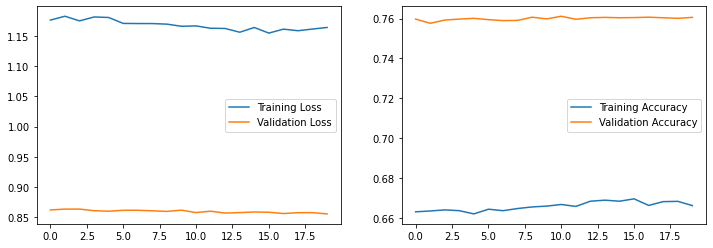

Loss: 1.1636
Acc: 0.6662
Val Loss: 0.8559
Val Accs: 0.7606


In [ ]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

print("Loss: {:.4f}".format(losses[-1]))
print("Acc: {:.4f}".format(accs[-1]))
print("Val Loss: {:.4f}".format(val_losses[-1]))
print("Val Accs: {:.4f}".format(val_accs[-1]))

In [ ]:
df_VALIDATION_copy = df_VALIDATION.copy()

In [ ]:
 df_Predict = create_prediction(df_VALIDATION_copy, batch_size=64,image_dir='/tmp/train/train')

In [ ]:
yPredict = df_Predict['category'].tolist()
yTrue = df_VALIDATION['category'].tolist()

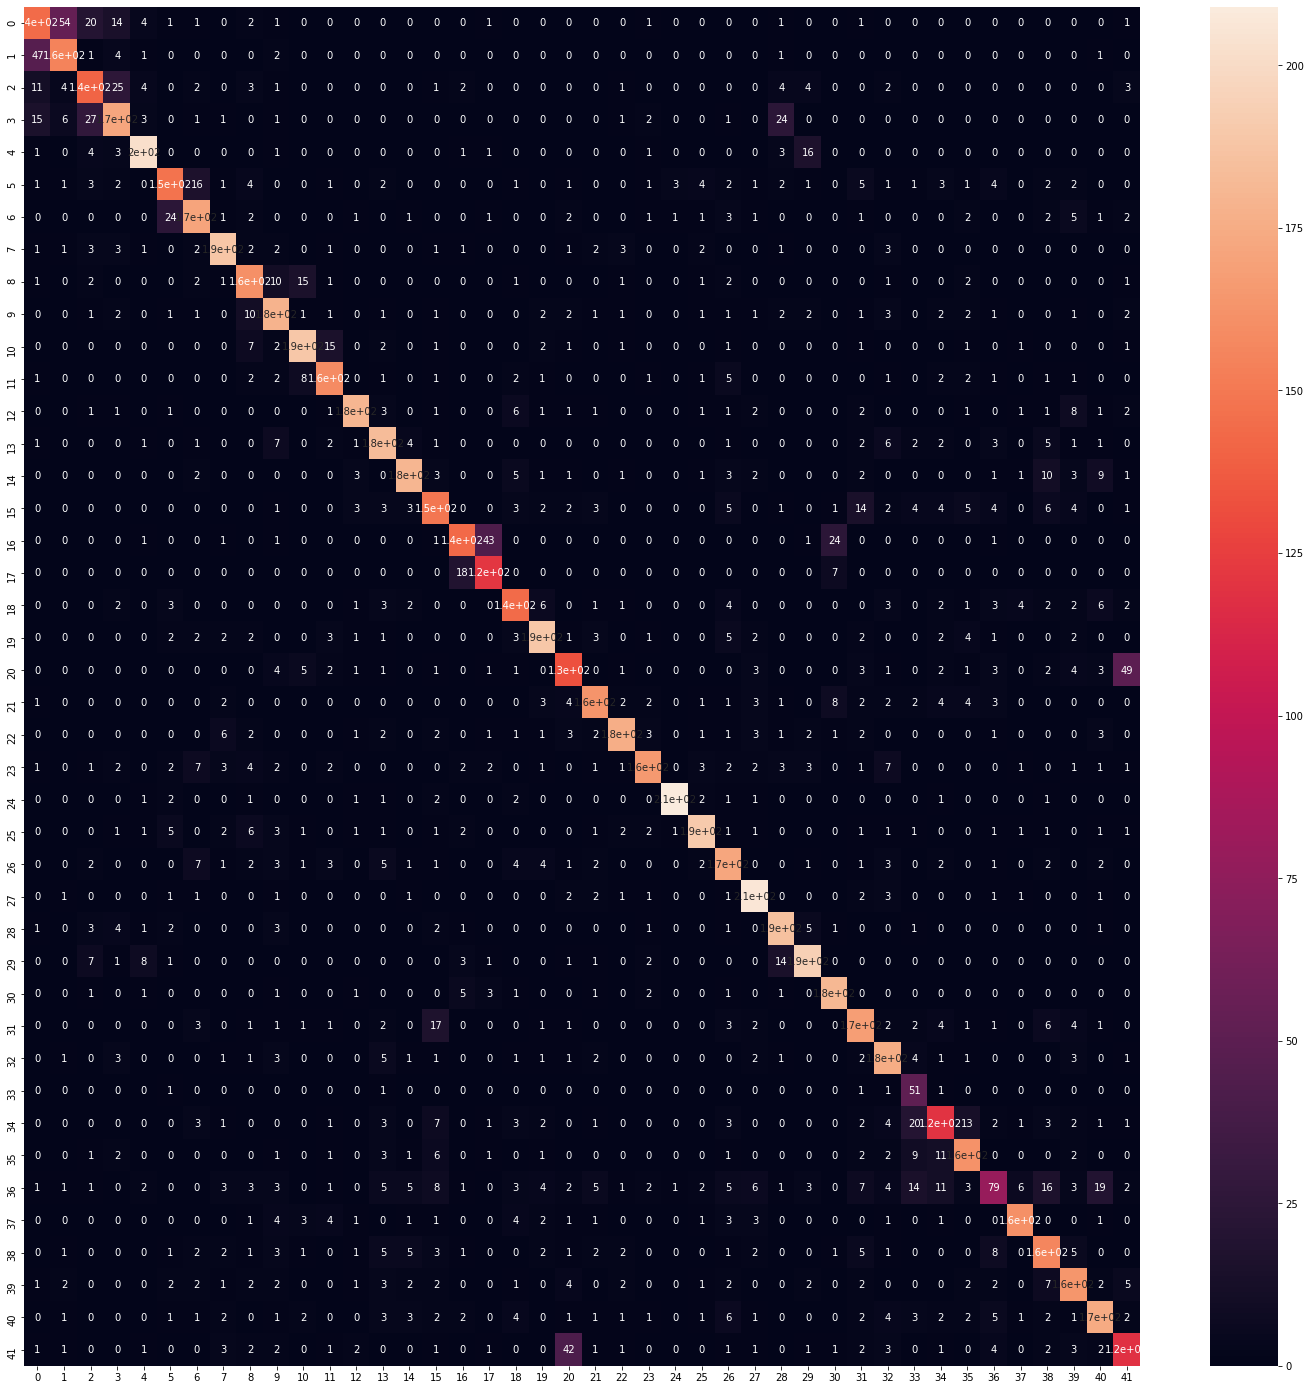

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yTrue, yPredict)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

# Predict

In [ ]:
def create_prediction(df, batch_size=8, image_dir='/tmp/test/test'):
    
    y = np.zeros((df.shape[0], 1))
    steps = int(df.shape[0]/batch_size)
    for i in range(0, steps+1):
        df_sub = df.loc[i*batch_size: (i+1)*batch_size].reset_index()
        if i == steps:
            batch_size = df.shape[0] % batch_size
        x = np.zeros((batch_size, 300, 300, 3))
        for j in range(0, batch_size):
            image = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, df_sub.loc[j,'filename']), 
                                                            target_size=(300,300))
            arr = tf.keras.preprocessing.image.img_to_array(image)
            arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            arr = np.expand_dims(arr, axis=0)
            x[j] = arr
        if i == steps:
            y[-batch_size:] = model.predict(x).argmax(axis=1).reshape(-1,1)
        else:
            y[i*batch_size: (i+1)*batch_size] = model.predict(x).argmax(axis=1).reshape(-1,1)
    df['category'] = y
    df['category'] = df['category'].apply(lambda v: str(int(v)).zfill(2))
    return df
df_submit = create_prediction(df_test, batch_size=64)
df_submit

filename category
0      fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       20
1      c7fd77508a8c355eaab0d4e10efd6b15.jpg       27
2      127f3e6d6e3491b2459812353f33a913.jpg       04
3      5ca4f2da11eda083064e6c36f37eeb81.jpg       22
4      46d681a542f2c71be017eef6aae23313.jpg       12
...                                     ...      ...
12181  5ba958eacb23cd7d1673bad4dae55784.jpg       16
12182  efbe41a1c2b666b70e337e438559808b.jpg       19
12183  79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg       38
12184  ac3d136124617637a05ba66694e381ef.jpg       15
12185  7ef61d7cfbad9cfe2db4f64560e3dddd.jpg       23

[12186 rows x 2 columns]

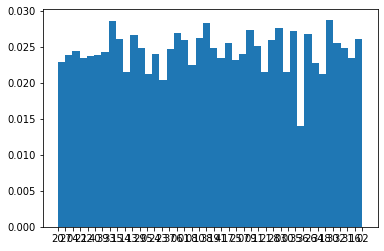

In [ ]:
plt.hist(df_submit['category'], bins=42, density=True)
plt.show()

In [ ]:
df_submit = df_submit.set_index(['filename'])
df_submit

category
filename                                     
fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       20
c7fd77508a8c355eaab0d4e10efd6b15.jpg       27
127f3e6d6e3491b2459812353f33a913.jpg       04
5ca4f2da11eda083064e6c36f37eeb81.jpg       22
46d681a542f2c71be017eef6aae23313.jpg       12
...                                       ...
5ba958eacb23cd7d1673bad4dae55784.jpg       16
efbe41a1c2b666b70e337e438559808b.jpg       19
79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg       38
ac3d136124617637a05ba66694e381ef.jpg       15
7ef61d7cfbad9cfe2db4f64560e3dddd.jpg       23

[12186 rows x 1 columns]

In [ ]:
df_submit.to_csv('/tmp/summit.csv')

สมมติ ว่า train เยอะๆ เช่น 10,000 epoch แล้ว Colab มันตัดไปซะก่อนครบ. เราก็ load จากของเดิม มา train ต่อได้

โดย run code เดิมทั้งหมดด้านบน ยกเว้น cell สุดท้าย (model.fit)

แล้วก็มา load model เก่าขึ้นมา train ต่อ

In [ ]:
!ls -al drive/"My Drive/Product_Detection/Checkpoints"/check*

-rw------- 1 root root        77 Jun 27 09:15 'drive/My Drive/Product_Detection/Checkpoints/checkpoint'
-rw------- 1 root root    144909 Jun 27 09:15 'drive/My Drive/Product_Detection/Checkpoints/checkpoint.data-00000-of-00002'
-rw------- 1 root root 368618896 Jun 27 09:15 'drive/My Drive/Product_Detection/Checkpoints/checkpoint.data-00001-of-00002'
-rw------- 1 root root     61547 Jun 27 09:15 'drive/My Drive/Product_Detection/Checkpoints/checkpoint.index'


In [ ]:
model.load_weights(checkpoint_path)

ValueError: ignored

In [ ]:
# train ต่ออีก 5 epoch เป็นตัวอย่าง
history = model.fit(train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 1,
            callbacks=[checkpoint]
            )

Epoch 1/5
741/741 [==============================] - 2632s 4s/step - loss: 1.3112 - accuracy: 0.6405 - val_loss: 1.0496 - val_accuracy: 0.7153
Epoch 2/5
741/741 [==============================] - 2634s 4s/step - loss: 1.3122 - accuracy: 0.6388 - val_loss: 1.0384 - val_accuracy: 0.7215
Epoch 3/5
741/741 [==============================] - 2630s 4s/step - loss: 1.2981 - accuracy: 0.6421 - val_loss: 1.0302 - val_accuracy: 0.7240
Epoch 4/5
303/741 [===========>..................] - ETA: 24:51 - loss: 1.2915 - accuracy: 0.6441